In [ ]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
device
RANDOM_SEED = 42

In [ ]:
from sklearn.datasets import make_moons

n_samples = 1000
X,y = make_moons(n_samples,
                 noise=0.07,
                 random_state=42)
len(X), len(y)

(1000, 1000)

In [ ]:
X[:4]

array([[-0.03341062,  0.4213911 ],
       [ 0.99882703, -0.4428903 ],
       [ 0.88959204, -0.32784256],
       [ 0.34195829, -0.41768975]])

In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label":y})
circles.head()

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


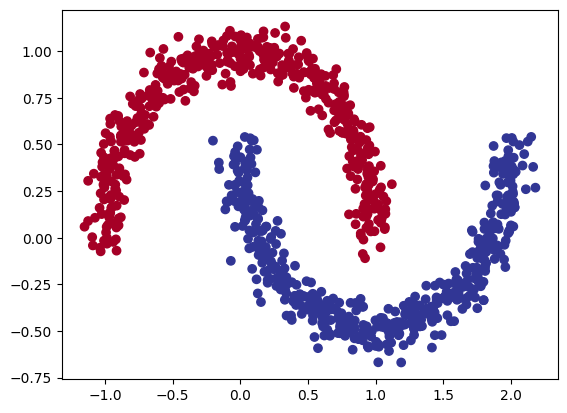

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=circles["X1"],
            y=circles["X2"],
            c=circles["label"],
            cmap=plt.cm.RdYlBu)

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
from torch import nn
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.SELU(),
            nn.Linear(in_features=10, out_features=20),
            nn.Mish(),
            nn.Linear(in_features=20, out_features=20),
            nn.LeakyReLU(),
            nn.Linear(in_features=20, out_features=10),
            nn.SELU(),
            nn.Linear(in_features=10, out_features=1),
            nn.SELU()
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [ ]:
model_1 = MoonModelV0().to(device)
model_1

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): SELU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): Mish()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): SELU()
    (8): Linear(in_features=10, out_features=1, bias=True)
    (9): SELU()
  )
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                          lr=0.001)

In [ ]:
torch.unique(y)

tensor([0., 1.])

In [ ]:
model_1(X_train.to(device))[:5]

tensor([[0.1404],
        [0.1715],
        [0.1571],
        [0.1561],
        [0.1420]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
#acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
#acc_fn

In [ ]:
def acc_fn(y_true,y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() ## eq diyor ki hey kaç tane y_pred y_true'ya eşit??
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
torch.manual_seed(RANDOM_SEED)

epochs=8000

X_train,X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass (logits output)
  y_logits = model_1(X_train).squeeze()

  # Turn logits into prediction probabilities
  y_prob = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_preds= torch.round(y_prob)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_true=y_train,
                           y_pred=y_preds) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()
  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_1(X_test).squeeze()
    # Turn the test logits into prediction labels
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits,y_test)
    test_acc = acc_fn(y_true=y_test,
                           y_pred=test_preds)

  # Print out what's happening every 100 epochs
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch}|| loss: {loss:.3f}, acc:{acc:.3f}|| test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


Epoch: 0|| loss: 0.698, acc:50.000|| test_loss: 0.698, test_acc: 50.000
Epoch: 1000|| loss: 0.689, acc:50.000|| test_loss: 0.689, test_acc: 50.000
Epoch: 2000|| loss: 0.682, acc:50.125|| test_loss: 0.682, test_acc: 50.000
Epoch: 3000|| loss: 0.658, acc:76.500|| test_loss: 0.660, test_acc: 76.000
Epoch: 4000|| loss: 0.631, acc:83.125|| test_loss: 0.635, test_acc: 83.000
Epoch: 5000|| loss: 0.588, acc:83.625|| test_loss: 0.595, test_acc: 79.500
Epoch: 6000|| loss: 0.531, acc:84.125|| test_loss: 0.541, test_acc: 80.500
Epoch: 7000|| loss: 0.466, acc:83.625|| test_loss: 0.478, test_acc: 82.500


In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

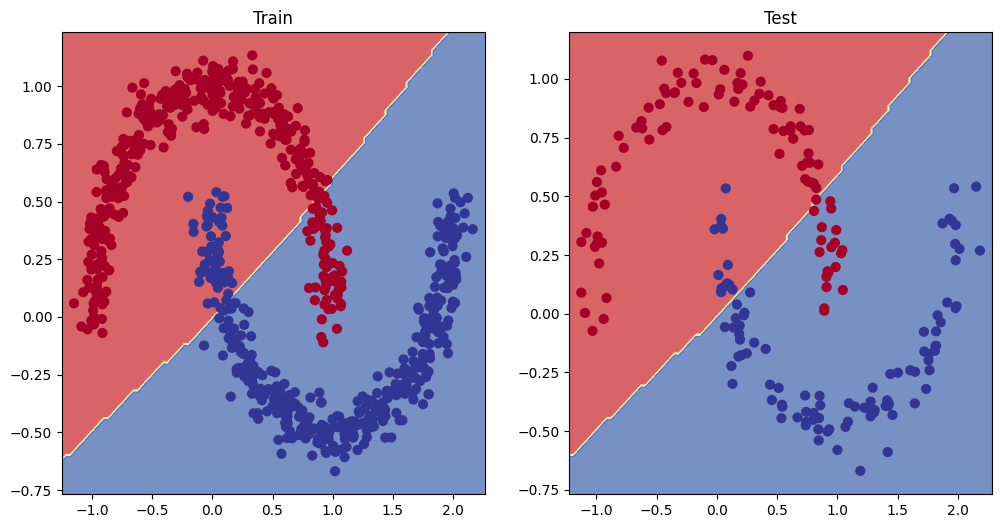

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

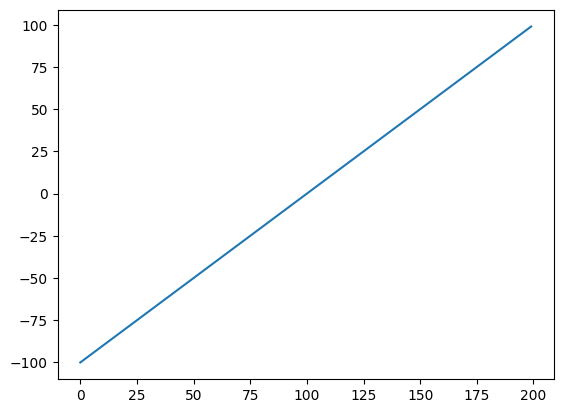

In [ ]:
# Create a straight line tensor
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

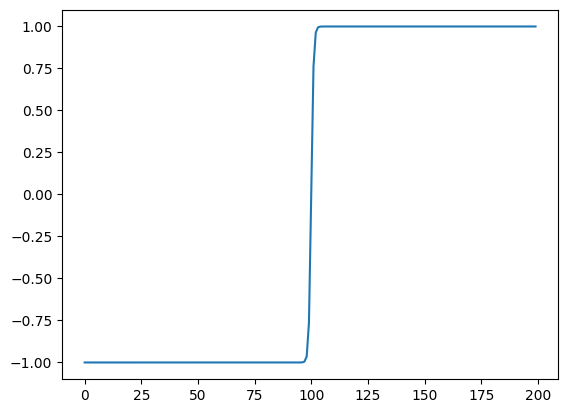

In [ ]:
#  Replication the Tanh (hyperbolic tangent) activation function in pure PyTorch
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(tensor_A))

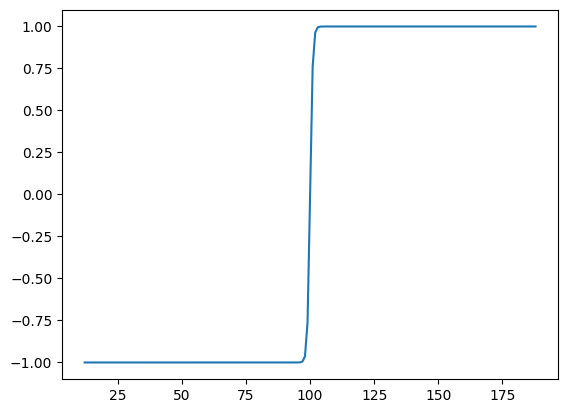

In [ ]:
# Replicate torch.tanh() and plot it
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

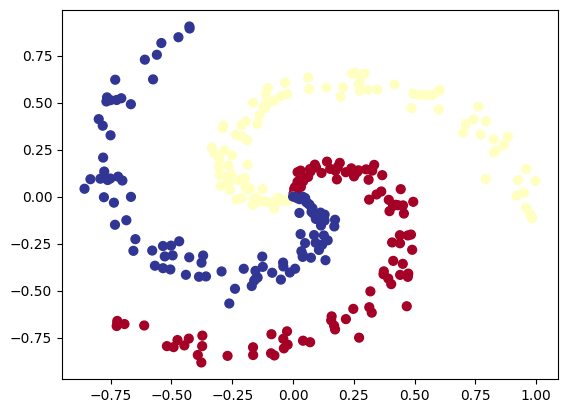

In [ ]:
### Multiiclass

# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dim
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42
                                                )


In [ ]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy


acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
class SpiralModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1=nn.Linear(in_features=2, out_features=10)
    self.linear2=nn.Linear(in_features=10, out_features=10)
    self.linear3=nn.Linear(in_features=10, out_features=3)
    self.relu=nn.ReLU()
  def forward(self,x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_2 = SpiralModelV0().to(device)
model_2

SpiralModelV0(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

print("Logits:")
print(model_2(X_train[:10]))

print("Pred probs:")
print(torch.softmax(model_2(X_train)[:10],dim=1))
print("Pred labels:")
print(torch.softmax(model_2(X_train)[:10],dim=1).argmax(dim=1))


Logits:
tensor([[-0.3621, -0.2138, -0.2310],
        [-0.3614, -0.2079, -0.2221],
        [-0.3471, -0.2292, -0.2296],
        [-0.2831, -0.2908, -0.2104],
        [-0.2988, -0.2787, -0.2243],
        [-0.3317, -0.2429, -0.2223],
        [-0.3408, -0.2369, -0.2274],
        [-0.3587, -0.2284, -0.2479],
        [-0.3358, -0.2374, -0.2223],
        [-0.2822, -0.2918, -0.2104]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Pred probs:
tensor([[0.3030, 0.3515, 0.3455],
        [0.3016, 0.3517, 0.3467],
        [0.3077, 0.3462, 0.3461],
        [0.3260, 0.3235, 0.3506],
        [0.3228, 0.3294, 0.3478],
        [0.3117, 0.3406, 0.3477],
        [0.3096, 0.3435, 0.3468],
        [0.3071, 0.3498, 0.3431],
        [0.3102, 0.3423, 0.3475],
        [0.3263, 0.3232, 0.3506]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1, 1, 1, 2, 2, 2, 2, 1, 2, 2], device='cuda:0')


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                            lr=0.02)

In [ ]:
epochs = 1000

for epoch in range(epochs):

  ## Training
  model_2.train()
  # 1. Forward pass
  y_logits = model_2(X_train)
  y_prob = torch.softmax(y_logits, dim=1)
  y_pred = y_prob.argmax(dim=1)
  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred,y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_2(X_test)
    test_pred = torch.softmax(model_2(X_test), dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits,y_test)
    test_acc = acc_fn(test_pred,y_test)
  # Print out what's happening every 100 epochs
  if epoch % 100 == 0 :
    print(f"Epoch: {epoch} || loss: {loss:.4f}, acc: {acc:.4f} || test_loss:{test_loss:.4f}, test_acc:{test_acc:.3f}")

Epoch: 0 || loss: 1.1139, acc: 0.1542 || test_loss:1.1065, test_acc:0.267
Epoch: 100 || loss: 0.1091, acc: 0.9750 || test_loss:0.0805, test_acc:1.000
Epoch: 200 || loss: 0.0424, acc: 0.9917 || test_loss:0.0125, test_acc:1.000
Epoch: 300 || loss: 0.0275, acc: 0.9917 || test_loss:0.0046, test_acc:1.000
Epoch: 400 || loss: 0.0221, acc: 0.9917 || test_loss:0.0021, test_acc:1.000
Epoch: 500 || loss: 0.0193, acc: 0.9917 || test_loss:0.0016, test_acc:1.000
Epoch: 600 || loss: 0.0177, acc: 0.9917 || test_loss:0.0012, test_acc:1.000
Epoch: 700 || loss: 0.0167, acc: 0.9917 || test_loss:0.0009, test_acc:1.000
Epoch: 800 || loss: 0.0160, acc: 0.9917 || test_loss:0.0008, test_acc:1.000
Epoch: 900 || loss: 0.0155, acc: 0.9917 || test_loss:0.0006, test_acc:1.000


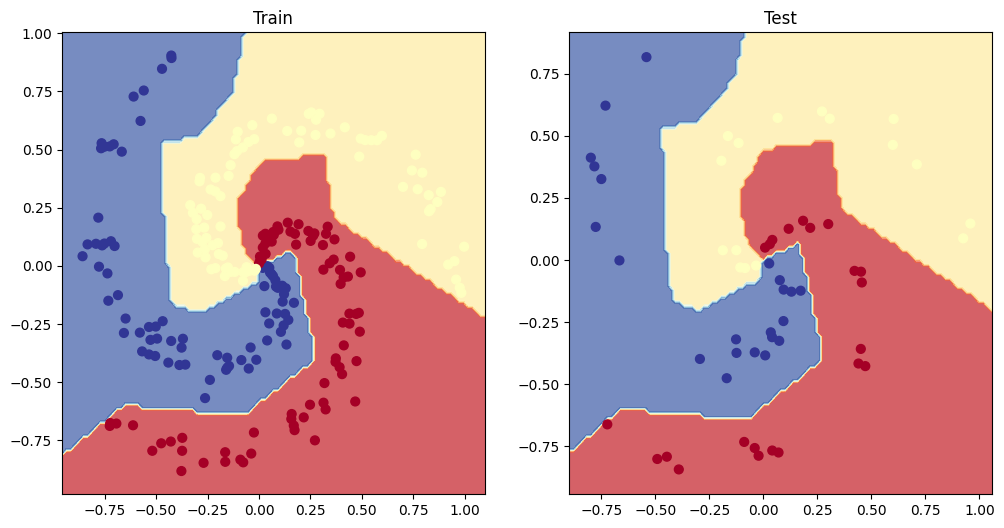

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)